# The Resurrection of Bob Ross

(2016)

Bob Ross was a peaceful painter, famous for his video series on teaching hobbyists how to paint landscapes and beautiful nature in general. Unfortunately, Bob passed away on July 4 1995, leaving his loved paintings behind. However, his legacy continues! In this notebook, I will apply some NLP (Natural Language Processing) and other machine learning techniques to process the transcripts of his video series in an attempt to create a model to guide us with our own paintings.

<img src="docs/BobRoss2.jpg" align="center" width="auto">

NLP processing is a field with a lot of unsolved problems. This notebook is an example that highlights a lot of the problems! 


If you want to learn more about Bob Ross, you can check out his 28 second long video trailer on Youtube: https://youtu.be/gqdzXNsL_2o

In [6]:
# Dependencies of this script:
import pysrt # dealing with .srt files
import enchant # libary to check spelling
import multiprocessing # Process-based “threading” interface (speeds up training of some of the models)

# NLP - Natural Language Processing (Machine Learning #1)
from gensim.corpora.wikicorpus import WikiCorpus
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import LineSentence
from gensim.models.word2vec import Word2Vec

# NTLK - Natural Language Toolkit
from nltk.corpus import stopwords # to remove stopwords
# nltk.download('stopwords') # execute this once

# plots
import matplotlib.pyplot as plt

from scipy import spatial # distance measure
import numpy as np # arrays
import math # standard math library
import sys # standard system library
import time # standard time library
import pickle # standard library to save variables

# data analysis library
import pandas as pd

# Multiclass Classification
import sklearn

## 1.1 Loading and exploring the data

The human-transcribed subtitles were downloaded from https://www.youtube.com/user/BobRossInc/ in .srt format. They are put in the _transcripts_ folder. With 'human-transcribed' I mean transcriptions that were not automatically generated by Youtube. Data of the first 7 seasons were downloaded and used here. One season contains about 13 videos of 30 minutes long.  

In [72]:
import os
transcript_dir = 'transcripts/'

**Load all the transcripts from the transcripts folder**

In [73]:
all_transcripts = [s for s in os.listdir(transcript_dir) if s.endswith('.srt')]
print('There are {} available transcripts!'.format(len(all_transcripts)))

There are 72 available transcripts!


**To get a basic idea of how a transcript looks like:**

In [74]:
example_transcript = pysrt.open(transcript_dir + all_transcripts[0])
full_text = '\n'.join([line.text for line in example_transcript])
print(full_text[0:500])

- Hi, welcome back.
I'm glad to see you today.
I'm very glad you could join me.
Today, I think we'll do a
fantastic little painting that
I think will make you happy
and do good things for you.
I'm gonna have them graphically run
all the colors across the screen,
and they'll come across your
screen in the same order
that I have them on my palette,
starting with the white and going around.
And while they're doing
that, let's go up here
and let's do a fantastic
painting together.
Gonna start today 


## 1.2 Parse the transcripts
Parse the transcripts into a list of full and complete sentences.

In [75]:
def remove_all_brackets(s):
    """Removes all brackets from the transcripts."""
    while s.find('(') != -1:
        start = s.find( '(' )
        end = s.find( ')' )
        if start != -1 and end != -1:
            s = s[0:start] + s[end+1:]
    return s

def transcript_to_fluent_text(transcript):
    """Restructuring and concatenating the transcripts into a more readable format."""
    sentences = list()
    current_sentence = ''
    for t in transcript:
        for c in t:
            current_sentence += c
            if c == '.' or c == '!' or c == '?':
                current_sentence = remove_all_brackets(current_sentence)
                current_sentence = current_sentence.replace('\n', ' ').replace('-', '')\
                .replace(',', ', ').replace('  ', ' ').strip().replace('<i>','').replace('</i>','')
                if current_sentence == '.':
                    sentences[-1] = sentences[-1] + current_sentence
                else:
                    if len(sentences)>1:
                        if sentences[-1][-3:] == '...':
                            sentences[-1] = sentences[-1] + ' ' + current_sentence
                    sentences.append(current_sentence)
                current_sentence = ''
        current_sentence += ' '
    return sentences

parsed_transcripts = list()
for j in all_transcripts:
    t = pysrt.open(transcript_dir + j)
    transcript = [line.text for line in t]
    parsed_transcripts.append(transcript_to_fluent_text(transcript))

CPU times: user 1.85 s, sys: 100 ms, total: 1.95 s
Wall time: 2.69 s


We have parsed the transcripts to now contain one full sentence per entry in the list. This is how it looks like for the first five sentences:

In [76]:
parsed_transcripts[-1][:5]

["Hi, I'm glad to see you today.",
 'Glad you could join me.',
 "Today I thought we'd do a black canvas And I've taken a black canvas here and I've covered the whole thing with Alizarin crimson and Thalo blue.",
 'And I just sort of mixed them on the brush and just covered the entire canvas.',
 "So I'll have 'em graphically run all the colors that you need across your screen."]

If you are using a Mac computer, you can run the following cell to make your computer read the above sentences for you. :-)

In [ ]:
import os
s = 'say "' + ' '.join(parsed_transcripts[-1][:5]) + '"'
os.system(s)

**We will take a look at the words contained in the transcripts and their abundance:**

In [77]:
def extract_words(parsed_transcripts):
    """Extract all words from the parsed transcripts and put them into a dictionary."""
    words = dict()
    for t in parsed_transcripts:
        for s in t:
            s = s.lower().replace('...', '').replace('.', '').replace('\n', '')\
            .replace(',', '').replace('!', '').replace('?', '').replace('"', '')
            s = s.split()
            for w in s:
                if w in words:
                    words[w] += 1
                else:
                    words[w] = 1
    return words

words = extract_words(parsed_transcripts)

The top 10 most used words:

In [78]:
x = sorted(words.items(), key=lambda x: x[1], reverse=True)[:10]
for (i, j) in x:
    print(i,':',j)

and : 9796
a : 8772
the : 8136
little : 6851
just : 5716
of : 5110
it : 4953
you : 4779
to : 4675
here : 4466


The least used words:

In [79]:
x = sorted(words.items(), key=lambda x: x[1], reverse=True)[-10:]
for (i, j) in x:
    print(i,':',j)

goodbye : 1
curved : 1
cage : 1
mountain'll : 1
desperately : 1
dines : 1
tends : 1
da : 1
starburst : 1
putty : 1


**Spell check the words, since the subtitles were made manually.**

Ideally, these spelling mistakes should be evaluated, but we will leave it like this for now.

In [80]:
def not_recognised_words(words):
    """Return potentially misspelled words from a list, using the 'enchant' en_US library."""
    not_recognised = list()
    dictionary = enchant.Dict("en_US")
    for w in words:
        if dictionary.check(w) == False:
            not_recognised.append(w)
    x = ''
    for i in not_recognised:
        x += i + '\t'
    return x

print(not_recognised_words(words.keys())[:1000])

looksee	dibbydoo	fenugreek	puttin'	usin'	underpaint	purty	water'll	copal	greatgrandfather	jaldi	lowling	grey	france	brushstrokes	onethird	mumbai	lefthanded	vandyke	treeit	monday	doop	doo	american	boop	ok	stringies	pression	une	twostar	saumon	rockytype	espagnole	beaucoup	chewin'	goin'	sockin'	cepe	colors:	chalo	kala	ou	nobody'd	hassan	'im	rigght	lettin'	murgh	underpainting	fillin	philtrum	bonsoir	souffle	barbeque	twoandahalf	pennisula	heighth	british	dropoff	nothin's	effect;	phthalo	differesco	water'd	mukhtar	1/2	everevident	oooo	protuding	onehaired	thelo	iqbal	saturday	alaskan	layin'	baleine	nothing's	crossways	inchbrush	m'kay	n'estce	india	doodoodoodoodoo	that''s	i've	'bout	'em	lookin'	nitro	masala	tim	wmvt	marseillaise	bein'	payne's	livin'	kadam	lets'	nah	bellowy	unpure	hayinfused	le	brushmixed	happenin'	haan	thierry	dododododododo	damar	'ole	everything's	world:	mmm	alaska's	shoom	have's	mistakes;	christmas	bastille	highlight'll	xes	boletus	kay	feuilleté	indian	jeanpierre	hzooop	yay	

## 1.3 Cluster sentences (unsupervised learning)

Next, we want to group similar sentences in clusters. This will enable us to find a pattern in the transcripts that explains when one cluster of sentences is used by mister Ross. 

<img src="docs/goal_of_clustering.png">

### 1.3.1 Calculate the similarity between two sentences

In order to accomplish the above, we need to go into the field of NLP (Natural Language Processing) to make the computer understand the content of the sentences in order to score their similarity. If we know what sentences are very similar, we know which ones to put together in the same cluster. 

Similarity scoring can be done by using Word2Vec. Word2vec takes as its input a large piece of text and produces a vector space, typically of several hundred dimensions, with each unique word in the piece of text being assigned a corresponding vector in the space. This sounds complicated, and it is, but the essence is that the model mathematically represents the words based on the surrounding words and sentences (= it's meaning derived through context). We are essentially teaching Word2Vec what each word means and where it is used (applied Machine Learning). To teach well, we need to input a large corpus of text examples. 

What better way to teach Word2Vec the 'meaning' of words than by using the entire English Wikipedia database, right?

#### 1.3.1.1 Training Word2Vec on Wikipedia

First, you should download all English Wikipedia articles. You can do this as follows:

- Find the code for the language you want, in this case English, which is represented by 'en'. In this case the url to the dumps is https://dumps.wikimedia.org/enwiki/latest/. We find this url by adding the language code 'en' before 'wiki' and the end of the first part of the link.
  
  
- Look for the file named enwiki-latest-pages-articles.xml.bz2 and download this (huge file!)


In [81]:
file_location = 'word2vec/enwiki-latest-pages-articles.xml.bz2' # change the filepath to the downloaded file here

def train_word2vec(path_to_data):
    """Train a Word2Vec model on Wikipedia Data. Warning: This takes 10+ hours on average!"""
    wiki = WikiCorpus(path_to_data, 
                      lemmatize=False, dictionary={})
    sentences = list(wiki.get_texts())
    # size is the number of features, this will be important later
    params = {'size': 300, 'window': 10, 'min_count': 10, 
              'workers': max(1, multiprocessing.cpu_count() - 1), 'sample': 1E-3,}
    word2vec = Word2Vec(sentences, **params)
    return word2vec

# refs: 
# - https://github.com/hgrif/wiki-word2vec
# - https://github.com/panyang/Wikipedia_Word2vec
# - http://textminingonline.com/training-word2vec-model-on-english-wikipedia-by-gensim

Run the following code to train: (WARNING: can take 10+ hours and uses a lot of computer recourses!)

To run the code, simply click the next block and change the type of the block from 'Raw NBConvert' to 'code' and press run.

In [ ]:
word2vec_model = train_word2vec(file_location)

# Save the model under a name to use later (change this to the desired output file path)
output_file = 'word2vec/wiki.en.text.w2vbinary' 
word2vec_model.wv.save_word2vec_format(output_file, binary=True)

After doing the above once, your Word2Vec model is ready for use. You reload it from the file:

In [82]:
# Load the model
input_file = 'word2vec/en.wiki.text.w2vbinary' # = output_file from the last block
word2vec_model = KeyedVectors.load_word2vec_format(input_file, binary=True)

# index2word
index2word = set(word2vec_model.index2word)

CPU times: user 20.2 s, sys: 4.03 s, total: 24.3 s
Wall time: 26.5 s


#### 1.3.1.2 Testing the trained Word2Vec model

As stated before, Word2Vec creates a vector space in order to represent the context (meaning) of the words. Therefore, to understand the meaning of a combination of words, we simply need to combine the vector representation. Again, this sounds complicated, but the following image will explain a lot:

(ref Tensorflow - https://www.tensorflow.org/tutorials/word2vec - image source and more information)
<img src="docs/word2vec_vectorspace_relationships.png">

This can be interpreted as follows: 

"a man is to a woman what a king is to a queen"

Let's put Word2Vec to the test. If we pass 'woman king' to Word2Vec and put 'woman' in contrast with 'man', we should be able to find 'queen' as result. See for yourself, given the top three results:

"Woman + King == Man + ???"

In [83]:
word2vec_model.most_similar(positive=['woman', 'king'], negative=['man'])[:3]

[('queen', 0.6773032546043396),
 ('princess', 0.5975905060768127),
 ('monarch', 0.5914919376373291)]

Another example, also related to politics:

"Trump + Republican == Obama + ???"

In [84]:
word2vec_model.most_similar(positive=['trump', 'republican'], negative=['obama'])[:3]

[('democrat', 0.6498938798904419),
 ('democratic', 0.5777391195297241),
 ('gop', 0.5344028472900391)]

#### 1.3.1.3 Applying the trained Word2Vec model 

We will apply the trained Word2Vec model to compute similarities between Bob Ross his sentences. The most similar sentences will be clustered together. We will create the pairwise_similarity function that has as inputs two sentences and as output a score. Generally, the cosine similarity (similarity = 1 - distance) tends to perform best.

First, we use Word2Vec to convert the words to their representation in the vector space. Secondly, we average these representations over the sentences. We then compute the cosine similarity between two average representations.

In [85]:
def avg_feature_vector(words, model, num_features, index2word_set):
    """Compute the average vector of the combination of words."""
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        if word in index2word_set:
            nwords = nwords+1
            featureVec = np.add(featureVec, model[word])

    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    return featureVec
    
def pairwise_similarity(sentence_1, sentence_2, num_features=300):
    """Compute the pairwise cosine distance between two vectors."""
    # get average vectors for both sentences
    sentence_1_avg_vector = avg_feature_vector(sentence_1.split(), model=word2vec_model, num_features=num_features, index2word_set=index2word)
    sentence_2_avg_vector = avg_feature_vector(sentence_2.split(), model=word2vec_model, num_features=num_features, index2word_set=index2word)
    
    # calculate similarity with spatial.distance.cosine
    sen1_sen2_similarity =  1 - spatial.distance.cosine(sentence_1_avg_vector,sentence_2_avg_vector)
    return sen1_sen2_similarity

# ref: 
# https://stackoverflow.com/questions/22129943/how-to-calculate-the-sentence-similarity-using-word2vec-model-of-gensim-with-pyt

#### 1.3.1.4 Performance Test 

We will compare one sentence with two other sentences. One sentence that is not very similar (Example 1) and another sentence that is more similar (Example 2).

In [86]:
main_sentence = "And this is much different than the traditional palette knife."

# 1
sentence_1 = "Be sure you don't start with a nylon brush."
print('Example 1:', pairwise_similarity(main_sentence, sentence_1, num_features=300))

# 2
sentence_2 = "I have a traditional palette knife in my back pocket."
print('Example 2:',pairwise_similarity(main_sentence, sentence_2, num_features=300))

Example 1: 0.255127590975
Example 2: 0.540638658672


Indeed, the score of the second, more similar sentence is 2 times as high as the score of the less similar sentence. 

### 1.3.2 Clustering Bob Ross his sentences together in different groups (classes) 

To cluster these sentences, I will go for the more intuitive approach. I don't claim that this is the best method, but it's probably one of easiest to understand.

**The method**

We will iteratively group the most similar sentences until the specified amount of clusters is achieved or the level of dissimilarity between clusters (or similarity within clusters) is achieved. This approach is called an ** agglomerative bottom-up approach**.

In practice, we start with all sentences in different clusters and we then iteratively select the two most similar sentences and group them in just one cluster (merging). We then look for the second most similar combination and add it together and so forth until the stopping criterium is satisfied. The stopping criterium will be a minimum within-cluster similarity score. 

<img src="docs/clustering_illustration.png">

#### 1.3.2.1 Clustering step 1: Get all unique sentences

In [87]:
unique_sentences = set()
for transcr in parsed_transcripts:
    for sentence in transcr:
        sentence = sentence.replace('"', '')
        unique_sentences.update([sentence.strip()])
print('We have',len(unique_sentences), 'unique sentences.')

We have 20862 unique sentences.


#### 1.3.2.2 Clustering step 2: Assign a unique ID to the sentences

In [88]:
i = 1
all_sentences = []
for s in sorted(list(unique_sentences)):
    all_sentences.append(('s'+str(i), s))
    i+=1
print(all_sentences[0:5])

[('s1', "'Cause I want this mountain to be in front."), ('s2', "'Cause at the bottom of the mountain we have mist, and now we have pollution."), ('s3', "'Cause clouds are free."), ('s4', "'Cause dark colors are needed to make the light color show."), ('s5', "'Cause everyone sees nature differently.")]


#### 1.3.2.3 Clustering step 3: Simplify the sentences

- removing short non-informative words like 'and', 'or', 'the', 'it', 'we',...

- removing punctuation marks

- putting everything in lower case

In [89]:
punctuation = ['.', ',', '!', '?', ':', '"', ';', '/', '&', '(', ')', '[', ']']
other_words_to_remove = ['okay']

def remove_stop_words(text, other_words_to_remove=[]):
    """Remove stop words from a piece of text."""
    s=set(stopwords.words('english'))
    for w in other_words_to_remove:
        s.update([w])
    return ' '.join(filter(lambda w: not w in s,text.split()))

for n,(id,sentence) in enumerate(all_sentences.copy()):
    # lowercase
    simple_sentence = sentence.lower()
    
    # remove punctuation
    for c in punctuation:
        simple_sentence = simple_sentence.replace(c, '')
        
    # remove stopwords with nltk
    simple_sentence = remove_stop_words(simple_sentence, other_words_to_remove)
    
    all_sentences[n] = (id, sentence, simple_sentence)

# make sure every simple sentence in all_sentences is valid:
removed_count = 0
for (id1, s1, ss1) in all_sentences.copy():
    if ss1.lower() == ss1.upper():
        removed_count += 1
        all_sentences.remove((id1, s1, ss1))
print(len(all_sentences), 'sentences left')
print(removed_count, 'sentences removed')

20734 sentences left
128 sentences removed


<img src="docs/sentence_illustration.png">

This is how the end result with the simplified sentences look like:

In [90]:
all_sentences[109]

('s111', 'A little bit more of the paintthinner.', 'little bit paintthinner')

The first element is the sentence ID, the second the original sentence and the third is the simplified sentence. We will do the clustering on the simplified sentences, because these contain the 'essence' of the sentence.

#### 1.3.2.4 Clustering step 4: Calculating pairwise similarities

Now to start clustering, we will start by computing all pairwise similarities between the simplified sentences (the core of the sentences) and add these in a list. To compute the distances (1-similarity), we will use the pairwise scores on word2vec vectors, poured into the pairwise_similarity function mentioned before.

Because a lot of distances need to be calculated and the process below is not efficient (quadratic in the amount of sentences; nested for loop), this process takes a very long time. The clustering itself will be done using efficient disjoint sets, but the process below needs to be optimized for future projects. 

In order to predict how much time it will take for the similarity calculations to run, I have collected the time required for a certain amount of sentences. With this data, a regression model of degree 2 was fitted. We will use this model to predict how long it would take the process to complete.

equation = 4e-05x^2 + 0.01x + -2.16
R^2 = 0.9997


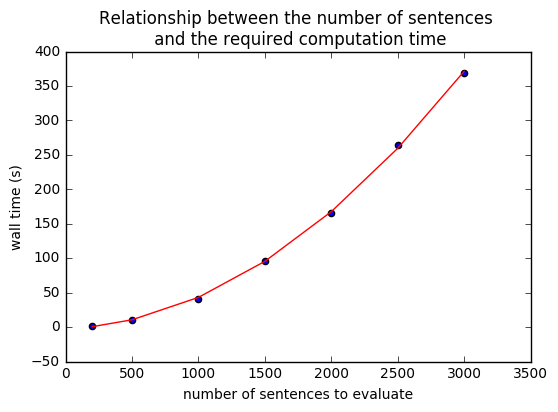

The time required for the similarity calculations is estimated at 5.0 hours.


In [91]:
# data
nr_of_sentences = [200, 500, 1000, 1500, 2000, 2500, 3000]
wall_time = [1.73, 10.2, 41.1, 96, 166, 264, 369]


# regression
coef = np.polyfit(nr_of_sentences, wall_time, 2)
model = np.poly1d(coef)
print('equation = {}x^2 + {}x + {}'.format(round(coef[0],5),round(coef[1],2),round(coef[2],2)))
wall_time_pred = model(nr_of_sentences)

y_res = wall_time - wall_time_pred
SSresid = np.sum(np.square(y_res))
SStotal = len(wall_time) * np.var(wall_time)

# calculate R^2
Rsq = 1 - SSresid/SStotal
print('R^2 = {}'.format(round(Rsq,4)))

# visualise in a plot
plt.scatter(nr_of_sentences, wall_time)
plt.plot(nr_of_sentences, wall_time_pred, "r")
plt.title('Relationship between the number of sentences \n and the required computation time')
plt.ylabel('wall time (s)')
plt.xlabel('number of sentences to evaluate')
plt.show()

# predict how long it would take
print('The time required for the similarity calculations is estimated at {} hours.'.format(round(model(len(all_sentences))/3600),2))

The blue points are the original data points, whereas the red line is the fit.

We calculate the similarities between every pair (= amount of sentences^2 times), but the similarity of sentence_X & sentence_Y is equal to the calculation between the reverse, sentence_Y & sentence_X. Half of the calculations would thus be unnecessary. Therefore the computational complexity is is equal to about ((amount of sentences)^2)/2.

Based on the computed similarity matrix, we will cluster the sentences. We will perform an iterative clustering approach with as stopping criterium a threshold of minimum within-cluster similarity. For good results (see further) we will cluster sentences that are very similar. Therefore, to save memory space, we will not save a pairwise similarity score if the similarity is low (<0.5). 

In [92]:
def compute_sentence_similarity_matrix(all_sentences):
    core_similarities = list()
    for index1, (id1, sentence1, core_sentence1) in enumerate(all_sentences):
        for (id2, sentence2, core_sentence2) in all_sentences[index1+1:]: 
            # using index1+1 because this makes sure that we dont make the same calculation twice 
            # and that we don't compare with self (would be similarity of 1 anyway)
            d = pairwise_similarity(core_sentence1, core_sentence2)
            if math.isnan(d) or d<=0:
                d = 1e-5
            # to save memory space we won't save similarities smaller than 0.5 since this is way below our clustering
            # stopping criterium
            if d > 0.5:
                core_similarities.append((d, id1, id2))
    print('Complete!\n')
    print(len(core_similarities), 'similarity scores saved.')
    return core_similarities

Run the cell below to start the computation of the pairwise similarity scores between the simplified sentences. We will compute the similarity (1-distance) between every pair of sentences:

In [ ]:
similarity_matrix = compute_sentence_similarity_matrix(all_sentences)

<img src="docs/similarity_matrix.png">

According to the magic time function, the computation took 5h 12min to complete on my machine, which is not too far from the estimate (5 hours).

#### 1.3.2.5 Clustering step 5: The actual clustering

Merging the sentences together in clusters is best done using 'disjoint sets'. This is an important concept in computer science, especially when designing algorithms. More information can be found on the wikipedia page of disjoint sets:

https://en.wikipedia.org/wiki/Disjoint-set_data_structure

To easily work with and implement the typical characteristics of disjoint sets, we define the disjoint_forest class below. 

In [93]:
class disjoint_forest():
    """disjoint_forest class to easily work with disjoint set"""
    def __init__(self, sentences):
        self._ids = sentences
        self._parent = {sentence : sentence for sentence in sentences}
        self._rank = {sentence : 0 for sentence in sentences}
    
    def find(self, x):
        if self._parent[x] is not x:
            self._parent[x] = self.find(self._parent[x])
        return self._parent[x]
            
    def union(self, x, y):
        xpos = self.find(x)
        ypos = self.find(y)
        if xpos == ypos:
            return
        if self._rank[xpos] < self._rank[ypos]:
            self._parent[xpos] = ypos
        elif self._rank[xpos] > self._rank[ypos]:
            self._parent[ypos] = xpos
        else:
            self._parent[ypos] = xpos
            self._rank[xpos] += 1
            
    def return_clusters(self):
        self._clusters = dict()
        for i in self._ids:
            if self.find(i) in self._clusters:
                self._clusters[self.find(i)].update([i])
            else:
                self._clusters[self.find(i)] = set([i])
                
        all_clusters = list()
        for cluster in self._clusters:
            all_clusters.append(self._clusters[cluster])
        return all_clusters
        
# ref course mathematical optimization (Ghent University)

We will cluster similar sentences by grouping the most similar sentences first. Then looking at the second most similar sentences and grouping these and continuing this process until the similarity between the next most similar sentences is below the threshold of minimum similarity. This is considered a form of hierarchical clustering. 

However, I don't want to do the similarity score calculation (5 hour) + clustering every time I work in this notebook. Therefore, I will save the output variable using the standard **pickle** library in python:

- pickle.dump(object, filename) to store the variable
- pickle.load(filename) to load the variable back in

pickle.dump is added to save the cluster dictionary below.

In [94]:
def cluster(all_sentences, core_similarities, min_similarity = 1e-5):
    """
    Clustering using the similarities between the sentences. 
    
    Args:
    min_similarity: the minimum within-cluster similarity
    
    Returns:
    cluster dictionary
    """
    # get all sentences ids
    all_ids = [sentence_id for (sentence_id,_,_) in all_sentences]

    # put all these in seperate trees
    forest = disjoint_forest(all_ids)

    # get all similarity scores
    similarities = sorted(core_similarities.copy(), key = lambda x: x[0], reverse=True)
    
    amount_of_clusters = len(all_sentences)
    while similarities[0][0] > min_similarity:
        # to cluster
        _, s1, s2 = similarities.pop(0)
        forest.union(s1, s2)
        
    return forest.return_clusters()

We are now applying the cluster function above and saving the clusters dictionary afterwards (using pickle). We will test different minimum within-cluster similarity thresholds and save these to see which performs best. 

In [ ]:
for min_similarity in (0.97, 0.95, 0.92, 0.9):
    # computing
    print('{} Starting computation for similarity threshold of {}'.format(time.strftime('%H:%M'), min_similarity))
    clusters = cluster(all_sentences, similarity_matrix, min_similarity = min_similarity)
    # saving
    with open('variables/clusters_{}.pickle'.format(min_similarity), 'wb') as outfile:
        pickle.dump(clusters, outfile)

To pick what threshold is best, we will return the distributions of the clusters. 

In [95]:
def cluster_distribution(cluster_filename, plot=False, ylim=0):
    '''Plot the size distribution of the clusters.'''
    with open(cluster_filename, 'rb') as infile:
        cluster = pickle.load(infile)
    sorted_clusters = sorted(cluster, key=lambda x: len(x), reverse=True)
    sizes = dict()
    for c in cluster:
        size = len(c)
        if size in sizes:
            sizes[size] += 1
        else:
            sizes[size] = 1
    if plot:
        plt.bar(list(sizes.keys()), sizes.values(), color='g')
        plt.xlabel('size of cluster')
        plt.ylabel('amount of clusters with this size')
        if ylim != 0:
            plt.ylim(0, ylim)
        plt.show()
    return sizes

In [96]:
cluster_distribution('variables/clusters_0.9.pickle')

{1: 12208,
 2: 843,
 3: 278,
 4: 104,
 5: 61,
 6: 43,
 7: 28,
 8: 20,
 9: 20,
 10: 15,
 11: 6,
 12: 6,
 13: 2,
 14: 3,
 15: 5,
 16: 5,
 17: 1,
 18: 4,
 19: 3,
 21: 3,
 22: 3,
 23: 1,
 24: 2,
 26: 2,
 27: 1,
 29: 1,
 31: 1,
 32: 4,
 35: 2,
 38: 1,
 44: 1,
 45: 1,
 84: 1,
 94: 1,
 2992: 1}

the number on the left  = size of the cluster

the number of the right = amount of clusters of this size

What this distribution tells us is that for a **similarity threshold of 0.9**, there are **12208 clusters of size 1** (non-clustered sentences) and **1 cluster with 2992 sentences**. It's really unlikely that there are 2992 sentences in one cluster, so we continue to the next threshold.

In [97]:
cluster_distribution('variables/clusters_0.92.pickle')

{1: 13802,
 2: 881,
 3: 278,
 4: 114,
 5: 76,
 6: 40,
 7: 31,
 8: 22,
 9: 20,
 10: 11,
 11: 6,
 12: 8,
 13: 7,
 14: 8,
 15: 5,
 16: 2,
 17: 3,
 21: 1,
 22: 1,
 23: 1,
 24: 2,
 25: 1,
 26: 3,
 27: 1,
 28: 1,
 34: 2,
 45: 1,
 46: 1,
 50: 1,
 71: 1,
 105: 1,
 176: 1,
 1221: 1}

There is **still one big cluster**, with **1221 sentences in one cluster**.

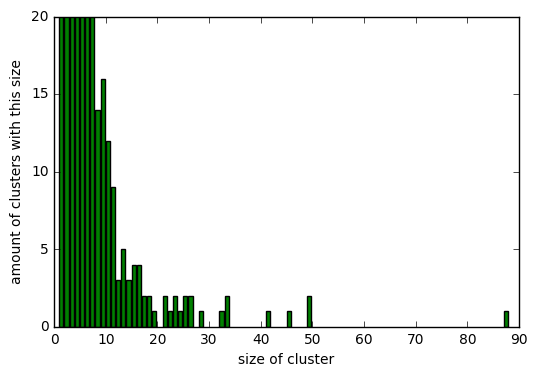

{1: 15634,
 2: 868,
 3: 251,
 4: 105,
 5: 54,
 6: 40,
 7: 31,
 8: 14,
 9: 16,
 10: 12,
 11: 9,
 12: 3,
 13: 5,
 14: 3,
 15: 4,
 16: 4,
 17: 2,
 18: 2,
 19: 1,
 21: 2,
 22: 1,
 23: 2,
 24: 1,
 25: 2,
 26: 2,
 28: 1,
 32: 1,
 33: 2,
 41: 1,
 45: 1,
 49: 2,
 87: 1}

In [98]:
cluster_distribution('variables/clusters_0.95.pickle', plot=True, ylim=20)

This looks more like it. The largest cluster is only 87 sentences big! **0.95 seems to be the ideal threshold so far.**

In [99]:
cluster_distribution('variables/clusters_0.97.pickle')

{1: 16346,
 2: 771,
 3: 222,
 4: 87,
 5: 58,
 6: 38,
 7: 25,
 8: 12,
 9: 12,
 10: 9,
 11: 9,
 12: 2,
 13: 6,
 14: 1,
 15: 3,
 16: 4,
 17: 2,
 18: 2,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 2,
 26: 1,
 29: 1,
 32: 1,
 33: 2,
 41: 1,
 48: 1,
 49: 1}

Increasing the threshold further above 0.95 will make the largest clusters even smaller. This is only required if the sentences in the cluster with 0.95 as similarity threshold don't seem similar in reality. We now have to check if the clustering was performed well.

The following function will reload the cluster based on the 0.95 similarity threshold and print out the contents of the largest clusters. Remember that we have performed the clustering on the core of the sentences; the simplified sentences. Therefore, we still need to map the cluster id to the original sentences. 

In [100]:
def load_and_check_cluster_contents(cluster_filename, all_sentences, top_x_clusters=20):
    with open(cluster_filename, 'rb') as infile:
        clusters = pickle.load(infile)
    # sort based on size
    sorted_clusters = sorted(clusters, key=lambda x: len(x), reverse=True)

    # create map between id and sentence
    id_to_sentence = dict()
    for entry in all_sentences:
        id_to_sentence[entry[0]] = entry[1]
    
    # print contents of the clusters
    for cluster_nr, cluster in enumerate(sorted_clusters[0:top_x_clusters]):
        print('\n\n CLUSTER', cluster_nr+1)
        for i in cluster:
            print(id_to_sentence[i])
    
    return sorted_clusters

We will use the function to print the composition of the biggest clusters and check if the grouped sentences actually are similar.

In [101]:
sorted_clusters = load_and_check_cluster_contents('variables/clusters_0.95.pickle', all_sentences, top_x_clusters=5)



 CLUSTER 1
Okay, maybe, maybe right in here.
Maybe there's, there it is, there it is.
Okay maybe, maybe.
Now maybe, maybe, there we go.
Okay, maybe right there, right there.
Maybe there's some out in here.
Maybe there it is.
And maybe, maybe.
Right about there, and maybe there.
Maybe, maybe.
Maybe right up through here.
Maybe, right there, yep.
Maybe, maybe, there he is.
Okay, maybe right in here.
Maybe maybe maybe maybe, yep.
Maybe there's a... Right here, there it is.
Maybe just right there.
Okay, now, maybe, maybe, maybe, maybe, right there.
Maybe right out on here.
And maybe over here.
And maybe up in here, there we go.
Let's go in here maybe.
Okay, maybe right down through here.
Maybe right over in here too.
Maybe, maybe, maybe, you can.
And maybe.
And maybe up here.
Maybe right here.
Maybe you are.
Maybe, there it is.
Maybe we'll have some over here.
Maybe, right in here.
Maybe, maybe, maybe, right there.
Maybe, maybe, there it is.
Okay, maybe, maybe, maybe, there's one right t

As the above illustrates very well, the clusters formed with about 95% similarity are quite good!

However, if we would not simplify the sentences first, the sentences would contain a lot more 'noise' due to stop words and punctuation marks. The clusters would not be as consistent in comparison to the ones based on the core of the sentences.

As final result from the above, we will create a dictionary where we number all clusters and put the full sentences in them. We no longer need the simplified sentences and the IDs. We will now map the full sentences to the cluster they belong in.

In [102]:
# map sentence ID's to full sentences
id_to_full = dict()
for ID, full_sentence, _ in all_sentences:
    id_to_full[ID] = full_sentence

In [103]:
# map cluster number -> set with sentences
cluster2sentence = dict()
for cluster_nr, cluster in enumerate(sorted_clusters):
    cluster2sentence[cluster_nr+1] = set()
    for sentence_id in cluster:
        # add full sentence
        sentence = id_to_full[sentence_id]
        cluster2sentence[cluster_nr+1].update([sentence])

# map sentence -> cluster number
sentence2cluster = dict()
for k,v in cluster2sentence.items():
    for w in v:
        sentence2cluster[w] = k

The result of this section, two dictionaries:

<img src="docs/sentence2cluster_cluster2sentence.png" align="center" width="auto">

NOTE: although the sentences are depicted here as the ids (s1, s2, ...), in reality the full sentences are in the dictionaries

### 1.3.3 Important remarks
Although the clustered sentences really did resemble each other, the large majority of sentences that were not clustered (15634 clusters of just one sentence out of 17077 clusters in total). We can attribute this to one of the following two causes (or both).

**1. Human language, even when only considering painting instructions, is extremely variable. There exist a lot of sentences with an entirely different meaning.**

Solution: 

- Gathering more data if possible. 

**2. The clustering was not optimal.**

Solutions:

- Consider implementing another clustering algorithm

- Manually correct and merge more clusters

The biggest problem is probably the first, the ambiguity and variability in human language. Gathering more data is a possibility and this can be done by downloading subtitles of the later seasons. However, the computation would be infeasible on your own computer and even with all seasons downloaded there would likely still not be enough data.

In the next section, we will try to use the clusters as classes for a classification model. This way, we could predict the next sentence based on the preceding sentence and create our own painting instructions, Bob Ross style!

There is one concern: the majority of the classes (clusters) contains just one sentence. This is extremely problematic, because we only have one observation (one sentence) that represents the class (the cluster). From a statistical viewpoint, we expect that this will result in a model with low accuracy. 

However, as this notebook is for teaching purposes (both for myself and to share methods with others), I will give it a try.

## 1.4 Bob Ross classification model (supervised learning)

### 1.4.1 Feature engineering

For every sentence we have the cluster to which it belongs. Now, from these sentences and their position in the transcript, we will create features.

Very often this is an iterative process. We start by trying one approach and based on the performance of the model we can engineer new features or remove others.

#### 1.4.1.1 Get all words

The first and most obvious approach to predict the next sentence based on the previous is to count which words are preceding and how many times we have observed each word. Therefore, we need a list of all words.

In [106]:
all_words = set()
for sentence in unique_sentences:
    # lowercase
    sentence = sentence.lower()
    
    # remove punctuation
    for c in punctuation:
        sentence = sentence.replace(c, '')
    
    # add to set if it's not a stop word
    all_words.update([word for word in sentence.split()])


# how many
print('There are',len(all_words), 'unique words.')

There are 4235 unique words.


From these unique words, we will remove the misspelled words, stop words and words that contain numbers from the list. This way we try to avoid fitting on a single occurrence of a misspelled word instead of the 'right' context represented by the other words.

In [107]:
def number_in_word(word):
    """Return True if there is a number in the word."""
    for letter in word:
        if letter in '0123456789':
            return True
    return False

In [108]:
# remove stop words, not recognised words and words that contain numbers from the list
all_stopwords=set(stopwords.words('english'))
unrecognised_words = not_recognised_words(all_words)
for word in all_words.copy():
    if word in all_stopwords or word in unrecognised_words or number_in_word(word):
        all_words.remove(word)

all_words = sorted(all_words)
# how many
print('There are',len(all_words), 'unique words after removing stop words and unrecognised words.')
print('Example of the remaining words:',all_words[0:5])

There are 3313 unique words after removing stop words and unrecognised words.
Example of the remaining words: ['abandoned', 'abduction', 'ability', 'abode', 'absolute']


#### 1.4.1.2 Create features

For every observed (~sentence) we now need to create a feature set based on these words.

Initially, we want the data entries to have the following format:

<img src="docs/feature_table.png">

So for every sentence we want to count the preceding words and put this into the table together with the cluster to which the sentence belongs. This way, we can train the model using the words of the previous sentences to predict the cluster number. When we predict the cluster number, we can pick a sentence from the cluster to create our own painting instructions.

First, we will map the words to a column in the datatable:

In [109]:
word_to_column = dict()
for index,word in enumerate(all_words):
    word_to_column[word] = index

Secondly, we will prepare the data table header:

In [110]:
datatable_header = np.array(all_words)
# the last column (index = -1) is going to be the cluster number
datatable_header = np.append(datatable_header, ['cluster_number'])
datatable_header = datatable_header.reshape((1,datatable_header.shape[0]))
print(datatable_header)

[['abandoned' 'abduction' 'ability' ..., 'zone' 'zoom' 'cluster_number']]


We will now loop over every sentence in the transcript and count the words in every transcript along the way. Run the following cell:

In [ ]:
datatable = np.zeros((1,datatable_header.shape[1]))
for transcript in parsed_transcripts:
    # initialise the word count and reset it for every transcript
    word_count = np.zeros(len(datatable[0]))
    for line in transcript:
        if line in sentence2cluster:
            # add it as a row to the data table
            
            # extract all words from the row
            words_in_line = extract_words([[line]])
            # update the row
            for word in words_in_line.keys():
                if word in word_to_column:
                    ix = word_to_column[word]
                    # increase the count for that specific word by the count in the sentence
                    word_count[ix] += words_in_line[word]
            
            # add cluster number and add the row to the datatable
            new_row = word_count.copy()
            new_row[-1] = sentence2cluster[line] # cluster number
            datatable = np.append(datatable, [new_row], axis=0)
datatable = datatable[1:]
with open('variables/datatable.pickle', 'wb') as outfile:
        pickle.dump(datatable, outfile)
print(datatable)

The feature matrix will be saved using pickle. This way we don't need to do the computation every time we work in the notebook.  We can load it back in using the following function:

In [121]:
with open('variables/datatable.pickle', 'rb') as infile:
        datatable = pickle.load(infile)

In [122]:
datatable = np.vstack((datatable_header, datatable))

In [123]:
index = np.array([int(float(i)) for i in range(datatable.shape[0]-1)]).transpose()
data = pd.DataFrame(data=datatable[1:], index=index, columns=datatable[0])
data.head()

,abandoned,abduction,ability,abode,absolute,absolutely,absorb,abstract,absurd,accents,...,you're,you've,young,yup,zero,zig,zip,zone,zoom,cluster_number
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7536.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6300.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,602.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14486.0


#### 1.4.1.3 Important remarks

What we have done in creating the matrix above is essentially what is done by the 'CountVectorizer' function of sklearn.

**There are some problems with creating a feature matrix in this type of NLP analysis:**
- the majority of the values in the matrix will be zero
- even though we reduced the amount of sentence classes by clustering, there are still way too much classes of sentences to ensure a good fit
- some sentences are alone in their cluster (class with just one observation). these are problematic if we want to split into a training and test set (see further)

These problems are quite common in this type of NLP analysis, with no clear solution available. One way to potentially improve the performance of the model is to create features in a different way.

**Additional ways to create features:**
- only save the words in the 5 preceding sentences instead of the entire transcript
- weigh the words: make some words more impactful than others (see Tf–idf term weighting on sklearn)

**Extra remarks**
- For information, representing sentences by it's words is called the 'bag-of-words' representation.
- Might be a possibility to improve the classification by stacking different classification algorithms on top of each other. For example passing the output of one classification algorithm as input for another classification algorithm.

### 1.4.2 Train and test split

In machine learning, it is highly recommended to split the data into a train set, validation/development set and testing set. This allows us to estimate parameters using the validation/dev set and to test the accuracy independently on new entries using the test set. 

However, in this study, we will **not** split the data in a training set and a testing set. Usually, the testing set would represent how well the model generalizes to other (real-world) observations, in contrast to the training data. It measures the general prediction performance of the model and indirectly prevents overfitting to the training data. 

In this study, we have a lot of classes (clusters) that contain only one sentence. In other words, if a class with only one observation is contained in the test set, the training set would not even have an observation for this class and the model does not know that that particular class exists. The test accuracy would therefore be very low. Additionally, we are not concerned with overfitting as it's not a problem in the context of painting instructions.

We will evaluate the model performance manually by checking the produced painting instructions.

For training purposes, we still need to split the class labels from the features:

In [124]:
train_y = data['cluster_number']
train_X = data.copy().drop('cluster_number', axis=1)

In [125]:
train_X.head()

,abandoned,abduction,ability,abode,absolute,absolutely,absorb,abstract,absurd,accents,...,you'll,you're,you've,young,yup,zero,zig,zip,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
train_y.head()

0     7536.0
1     6300.0
2      463.0
3      602.0
4    14486.0
Name: cluster_number, dtype: object

### 1.4.3 Fitting the multi-class classification model

A collection of multi-class classification models can be found on:

http://scikit-learn.org/stable/modules/multiclass.html

Let's start off by checking some out of the box sklearn classifiers:

In [117]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [58]:
sklearn_classifiers_dict = {'KNearestNeighbors_5': sklearn.neighbors.KNeighborsClassifier(n_neighbors=5),
                            'DecisionTree': DecisionTreeClassifier(),
                            'RandomForest_10': RandomForestClassifier(n_estimators=10)}

for algo in sklearn_classifiers_dict.keys():
    clf = sklearn_classifiers_dict[algo]
    clf.fit(train_X, train_y)
    print('The {} algorithm scored {} on the training dataset.'.format(algo, clf.score(train_X, train_y)))

The RandomForest_10 algorithm scored 0.8501342653765824 on the training dataset.
The KNearestNeighbors_5 algorithm scored 0.2207067047440433 on the training dataset.
The DecisionTree algorithm scored 0.8835940496995013 on the training dataset.
CPU times: user 5min 34s, sys: 1min 56s, total: 7min 30s
Wall time: 8min 10s


The following take a lot longer to fit. Run them if you want, but we will continue with the faster algorithms from above.

In [ ]:
sklearn_classifiers_dict = {'LogisticRegression_ovr': sklearn.linear_model.LogisticRegression()}

for algo in sklearn_classifiers_dict.keys():
    clf = sklearn_classifiers_dict[algo]
    clf.fit(train_X, train_y)
    print('The {} algorithm scored {} on the training dataset.'.format(algo, clf.score(train_X, train_y)))

In [ ]:
sklearn_classifiers_dict = {'LinearSVC_ovr': sklearn.svm.LinearSVC(multi_class='ovr'), 
 'LinearSVC_cs': sklearn.svm.LinearSVC(multi_class='crammer_singer')}

for algo in sklearn_classifiers_dict.keys():
    clf = sklearn_classifiers_dict[algo]
    clf.fit(train_X, train_y)
    print('The {} algorithm scored {} on the training dataset.'.format(algo, clf.score(train_X, train_y)))

We will continue with the Random Forest Classifier, which is a collection of decision trees. We will play around with the parameter 'n_estimators' to find an optimal amount of trees in the forest. This step is usually done on the validation set, but for the reasons mentioned above we will do it on the training set.

In [ ]:
trees, scores = list(), list()
for n in np.arange(5,20,2):
    clf = RandomForestClassifier(n_estimators=n)
    clf.fit(train_X, train_y)
    score = clf.score(train_X, train_y)
    trees.append(n)
    scores.append(score)
    print('n_estimators = {}, training set accuracy = {}'.format(n, score))

The python kernel on my machine dies when fitting with n_estimators > 13. So we will end the computation there.

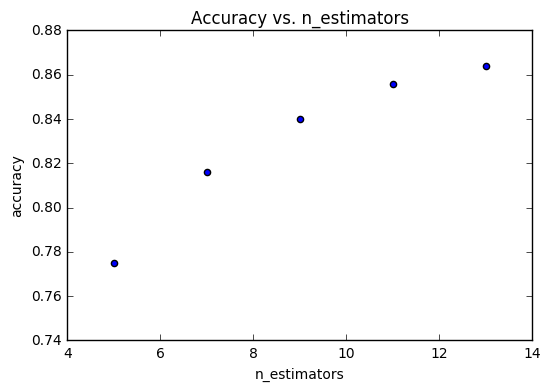

In [7]:
%matplotlib inline
trees = [5,7,9,11,13]
scores = [0.775, 0.816, 0.840, 0.856, 0.864]
plt.scatter(trees, scores)
plt.title('Accuracy vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.show()

We will continue with the RandomForestClassifier with n_estimators = 13. 

In [47]:
BobRoss = RandomForestClassifier(n_estimators=13)
BobRoss.fit(train_X, train_y)
print('Training accuracy:',BobRoss.score(train_X, train_y))

Training accuracy: 0.865777247347


### 1.4.4 Generating our own painting instructions

In order to predict the next sentences based on the previous, we first need to write at least one starting sentence ourselves. 

In [4]:
new_transcript = ['I would like to paint mountains, water and happy little trees.']

# the number of sentences you want the transcript to contain
max_transcript_length = 50

-  Initialise feature list, classification model and maximum transcript length

-  Extract the words

-  Update feature list

-  Predict next sentence

In [ ]:
# Initialise feature list and model
features = np.zeros((1, train_X.shape[1]))
BobRoss = RandomForestClassifier(n_estimators=13)
BobRoss.fit(train_X, train_y)

new_train_X, new_train_y = train_X, train_y

while len(new_transcript) < max_transcript_length:
    # 1) extract words from last sentence
    last_sentence = new_transcript[-1]
    words = extract_words([[last_sentence]])
    
    # 2) Update feature list
    for word in words.keys():
        if word in word_to_column:
            features[0][word_to_column[word]] += int(words[word])
    
    # 3) predict next sentence
    next_sentence_cluster = BobRoss.predict(features)
    sentences_in_cluster = cluster2sentence[float(next_sentence_cluster[0])]
    while len(sentences_in_cluster) == 0:
        # refit model without that cluster if all sentences in the cluster are used up
        cluster_ix = new_train_y != str(next_sentence_cluster)
        new_train_X, new_train_y = new_train_X[cluster_ix], new_train_y[cluster_ix] 
        BobRoss.fit(new_train_X, new_train_y)
        next_sentence_cluster = BobRoss.predict(features)
        sentences_in_cluster = cluster2sentence[float(next_sentence_cluster[0])]
        
    next_sentence = sentences_in_cluster.pop()
    new_transcript.append(next_sentence)
    print(next_sentence)

The result:

> If you've been with us before, I hope you have your almighty easel set up, and you're all ready to go along with me and paint a fantastic little painting.

> Hope you have your easel set up and you're ready to paint along with me this day.

> And today, I hope you've got your palette set up, and a big glass of iced tea there, and you're ready to paint along with me.

> You got your palette ready, your easel set up, big glass of tea right beside you?

> Thought today we'd show you how to do snow.

> How do you make it look like the snow is falling?

> So I thought that's what we'd do today.

> Today I thought we'd do it with this.

> Today I thought we'd do a little painting that's just a lot of fun and I really think you'll enjoy it.

> I've already covered the canvas with a thin, even coat of magic white, so it's wet, slick, and ready to go.

> I've already covered the canvas with a thin even coat of magic white, and it's wet and slick and ready to go.

> Now I've already covered this canvas with a thin, even coat of Magic White so it's nice and wet and slick and ready to go.

> I've already covered the canvas with a thin, even coat of Magic White, so it's wet and ready to go.

> I've already covered the canvas with a thin even coat of Magic White and we're ready to go.

> So, I'm gonna start here with a little bit of Prussian blue.

> I'm gonna start off here today with a little bit of Prussian blue.

> That'll set it off, even a little bit more off into the distance.

> I thought today we'd do a very quick happy little waterfall.

> Alright, we're going to run the colors across the screen in case you didn't get them last week, and just let you see all the colors that we use on each series here.

> And it'll pay you to wipe the brush in between because you're gonna pick up a little bit of that blue.

> Just drop them in real quick.

We immediately see that there is a lot of repetition in the transcript. We tweak the script by making sure the model refits without the already used clusters to avoid repetition.  

In [ ]:
# Initialise feature list and model
features = np.zeros((1, train_X.shape[1]))
BobRoss = RandomForestClassifier(n_estimators=13)
BobRoss.fit(train_X, train_y)

new_train_X, new_train_y = train_X.copy(), train_y.copy()

while len(new_transcript) < max_transcript_length:
    # 1) extract words from last sentence
    last_sentence = new_transcript[-1]
    words = extract_words([[last_sentence]])
    
    # 2) Update feature list
    for word in words.keys():
        if word in word_to_column:
            features[0][word_to_column[word]] += int(words[word])
    
    # 3) predict next sentence
    next_sentence_cluster = BobRoss.predict(features)
    sentences_in_cluster = cluster2sentence[float(next_sentence_cluster[0])]

    
    # refit model without that cluster
    cluster_ix = new_train_y != str(next_sentence_cluster[0])
    new_train_X, new_train_y = new_train_X[cluster_ix], new_train_y[cluster_ix] 
    BobRoss.fit(new_train_X, new_train_y)
    
    next_sentence = sentences_in_cluster.pop()
    new_transcript.append(next_sentence)
    print(next_sentence)

This is the result:

You don't have to read through all of it, you can find the remarks below the text

> START: I would like to paint **mountains**, **water** and happy little **trees**.

> Hi.

> Son of a gun.

> And, some on this side.

> Arrey, Hassan.

> Hello, I'm Bob Ross and I'd like to welcome you to the fourth Joy of Painting series.

> For the next 13 shows, I'll be your host as we explore this fantastic method of painting and if this is your first time with us, I think you'll find this a very exciting method of oil painting.

> We're gonna take here and use some very simple tools, a dozen colors, and I'm gonna show you how to do fantastic things.

> So let's start out here, and I'm gonna cover the entire canvas with a thin, even coat of magic white.

> Now magic white is a liquid paint that makes the canvas wet and makes it slick and allows things to happen right here on the canvas.

> We allow color to blend on the canvas rather than worry about mixing it on the canvas.

> There we go, there's some more.

> Use long horizontal and vertical strokes to make sure you have a nice, even distribution of magic white across the canvas.

> And we're ready to go.

> Today I'm gonna use a very very limited palette, we're only going to use about four colors and I'm gonna have them graphically run those colors across the screen so you can pick them up at home.

> These colors will come across your screen in the same order that I have them on my palette, starting with the white and working across.

> Let me wash the brush and we wash our brushes with odorless paint thinner and I have a screen in the bottom of my can that I scrub the brush against to remove the paint.

> Shake off the excess There we go, that's the most fun part of it.

> Okay today, let's mix up a purple color and I'll take alizarin crimson, we might as well mix up a pretty good batch, we're going to be using it all through this little painting and thalo blue.

> Now the blue is many, many times stronger than the alizarin crimson so use very little, very little in comparison to the crimson.

> Okay, pick the paint up off the palette and turn it over when you're mixing it, that assures it is mixed very thorough.

> There, and we'll mix this pretty thoroughly.

> Now it's very hard to tell what color you have here, it just looks black so let me wipe off the knife and we'll take a little bit of white and then we'll touch that and we'll check it, we'll see what we have here and if that's the color that we're looking for and that's pretty good color so we'll use it.

> So now, with a large two and a half inch brush, I'm gonna take just a little bit of the color on the brush and really work the paint into the bristles, work it into the bristles so you have a nice, even distribution of color.

> Now then, let's go to the canvas maybe right in here.

> I'm gonna start right at the top of the canvas and make little criss cross strokes, little x's.

> It's easy to make a sky darker but it's a son of a gun to make it lighter so use very little paint, you can always add more.

> Go all the way across the top using the little criss cross strokes and begin blending downward.

> Now your color is mixing with the magic white and automatically, it gets lighter as it goes toward the horizon and that's what we're looking for.

> As things get closer to you in the landscape, it should get darker in value.

> Okay, we'll take a little more color, just go right up here, still making the little criss cross strokes and blend downward so that it gets much, much lighter right here at the horizon.

> Very gently we'll blend that.

> Now while I've got the color on the brush, I'm gonna load a little bit more and we'll have some **water** down here at the bottom.

> One thing about water, if it's still water, it's always flat so pull from the outside in, the outside in and keep these strokes as straight as possible, it'll make your water flat, make it lay down.

> Very gently just blend it all together.

> This is three hairs and some air, just barely caressing the canvas.

> Okay, now we'll come from the other side and do the same thing.

> As I say, if this is your first time joining us, you'll notice that we do not do any tracings, we use no patterns, we just sort of let these paintings flow right out of our heart and you can too.

> so it makes it fantastic.

> Let's clean our brush off.

> Once again, we use odorless paint thinner.

> Alrighty, let's use the fan brush some today and I'm gonna go right back in here and I'm gonna use the same dark color and figure out, maybe there's a **tree** line that lives right there, there it is.

> And all I'm doing here is touching the canvas and pulling down.

> Touch and pull down, I'll try to hold the brush sideways so you can see that close up.

> Touch and pull down, okay?

> And we just sort of let this wander right on back and we're still using the same purple color, lavender color, purple.

> And just let 'em fade right out to nothing.

> Okay, now let's bring this little **hill**, I know this is gonna be a little hill right here, I see a little hill.

> Bring it down just like so and then lift gently upward, I'm just touching and lifting straight up, straight up.

> Good, now I want to create the illusion of mist so we'll take the large brush and, very gently, I'm gonna tap the bottom of this, just tapping.

We started with a sentence that contained the words **mountain**, **water** and **trees**. We therefore also expect that because the starting features have non-zero values for mountain, water and trees, we will have a transcript that includes these shapes of nature.

The result is a transcript that starts off in a weird way (especially the first 4 sentences), but comes together as the transcript becomes longer. It looks quite coherent and shows instructions containing **water**, **trees** and a **hill** in this order.

However, if you would actually paint following these instructions, you will probably have a very bad time...

### 1.4.5 Evaluation and final remarks

**clustering**

As discussed before, the clustering step can probably be improved. Too many sentences are not clustered together, which is expected, but a manual correction is recommended.

**feature engineering**

We should definitely explore the possibilities by designing other features and making combinations of existing ones. This could really improve the performance of the model a lot. This step is extremely crucial. 

**train test split**

The train test split remains a very hard problem because the data is very limited. We also need to come up with a metric that evaluates the quality of the entire transcript and how well it actually guides us while painting. A lot time can be spent here. 

**the model**

The choice was made to go with a random forest without evaluating many other possibilities. If we wish to increase the performance, we need to evaluate different models. Also, for determining optimal parameter values, it's a good idea to check different settings on a validation set. However, the computational recourses available for this intensive task were not available.

**evaluating the transcript**

I manually read through and evaluated one transcript. As mentioned above, a satisfying evaluation metric should be created and more transcripts should be generated to get a read on the general performance of our Bob Ross model. 

**general remark**

NLP is a very interesting field, but also very hard to model mathematically due to the variability and the ambiguity of the human language. Hopefully the future brings us smarter and more straight forward approaches on how to tackle a problem of this size and complexity. 